# Example: Mediation analysis and direct effects

## Setup

Lest start with loading all the dependencies we used in this example. 

In [1]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar, Callable

import torch
import torch.nn as nn
import pandas as pd

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample, PyroParam

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import MultiWorldCounterfactual

## Overview: mediation analysis

### Task: identify the (in)direct causal role of a variable

Understanding the mechanisms by which an intervention achieves its effect can have serious consequences for what treatments or policy changes. For instance, a smoking prevention program, among other things, might involve changing a person's work break habits. In this scenario we need to determine the extent to which the program's effect is mediated by this variable, which is an example of an *indirect effect*. Or, in a work discrimination case, we might want to examine how much the mistreatment of minority members is the *direct effect* of their minority status, and how much it is mediated by, say, education, to which they have lower access. While talking in terms of the distinction between the direct and the indirect effect is standard, as our example will illustrate, mediation analysis can be applied whenever there are two disjoint (sets of) paths from the input to the output variable, and we want to isolate and evaluate the impact that proceeds through one of them.

### Challenge

Let's take a seemingly straighforward case where the underlying causal structure is *Minority* $\rightarrow$ *Education*, *Minority* $\rightarrow$ *Salary* and *Education* $\rightarrow$ *Salary*. The traditional approach to understanding the direct impact of *Minority* on *Salary* would be to run a regression analysis with both *Minority* and *Education* as input variables, and *Salary* as the output. The resulting coefficient corresponding to *Minority* would be considered the impact of this variable, correcting for education levels. However, this approach assumes that there are no confounders between the mediator (*Education*) and the output (*Salary*). For instance, a confounder might be the subject's parents' socioeconomic status, which could impact both *Education* and *Salary*: *Education* $\leftarrow$ *Status* $\rightarrow$ *Salary*. In such a case, by conditioning in a regression analysis  on *Education*, which now is also a collider, we would open the path *Minority* $\rightarrow$ *Education* $\rightarrow$ *Status* $\rightarrow$ *Salary*, potentially introducing bias into the analysis. 

To better understand the impact of a treatment or a policy change, we need a further distinction. For instance, suppose a treatment ($T$) has a direct impact on disease ($D$), and also causes nausea, which in turn may motivate the patient to use a countermeasure ($C$) that may affect $D$. One question we can ask is about the *total effect* of $T$ on $D$, $P(D_{t} = d) - P(D_{t'} = d)$, where  $P(D_{t} = d)$ is the probability that $D=d$ in the intervened model in which $T$ is set to $t$. 

If we want to determine whether the use or certain levels of countermeasures should be discouraged, we need to conduct a mediation analysis. But which probabilities should we compare? On one hand, with respect to any level $c$ of $C$, we might want to know if a given untreated patient would get better if treated, holding $c$ fixed. If we proceed so, we are interested in the *controlled* direct of effect(s) of treatment on $D$ (different levels of $c$, in principle, could be connected with different direct effect levels), $P(D_{tc} = d) - P(D_{t'c} = d)$ for various settings $c$ of $C$ and different settings of $t$ and $t'$. Alternatively, we might want to take the *natural* levels of $C$ in a given patient into account (say, we know their use level of $C$ if untreated would take some particular value $c$). In this scenario, we use the same formula, but we are only interested in what value it leads to when $c$ is held constant. In the latter scenario, which more realistically abides by the constraints our policy will have to obey, we are estimating the *natural direct effect*. 

One way to see the difference is imagining it is possible to eliminate the nauseating effect of the treatment (notice how this intervention cannot be expressed in terms of the $do$ operator relative to this model, as it consists in the de-activation of a path, rather than setting a variable to a particular value). The question now is, whether this would in any way change the effect of the treatment. Estimating the controlled direct effect would not answer the question, as this change does not result in the population uniformly using a prescribed level of countermeasures. And in general, if there is no feasible intervention that can keep $c$ at a prescribed level, the controlled direct effect is not the estimand that we are after. In contrast, if we assume that each user sticks to their pre-treatment levels of countermeasures and we ask about the direct effect, we're estimating the natural direct effect. The general phenomenon is that controlled direct effect is of interest to a policy maker if the value of the mediator can be fixed by an intervention, while the natural direct effect is of more interest if the intervention is more nuanced.

The seminal paper discussing these distinctions and various types of mediation is  Pearl's [Direct and indirect effects](https://ftp.cs.ucla.edu/pub/stat_ser/R273-U.pdf). A somewhat more recent general framework is described in [Nested Counterfactual Identification from Arbitrary Surrogate Experiments](https://proceedings.neurips.cc/paper/2021/hash/36bedb6eb7152f39b16328448942822b-Abstract.html) by Juan Correa, Sanghack Lee, and Elias Bareinboim.

### Definitions

Since the distinctions that we have made are somewhat convoluted, unlike in the other examples, we will also frontload the explanation with the corresponding definitions. Suppose we are given a model $M$ with graph $G$, we are looking at treatment of the intervention $X=x$ on $Y$, given a context $U=u$, assuming the mediator $M$ is set to $m$. The value that $Y$ would have after the intervention fixing $X$ to $x$ in a  context $u$ is denoted as $Y_{x}(u)$. 

1. **Controlled unit-level direct-effect**.  $$CDE_z(Y, u; x, x') = Y_{xz}(u) - Y_{x'z}(u)$$ 

2. **Average controlled direct effect** $$ACDE_z(Y; x, x') =  \mathbb{E}(Y_{xz} - Y_{x'z})$$

3. **Unit-level natural direct effect** $$NDE(Y, u; x, x') = Y_{x, Z_x'(u)}(u) - Y_{x'}(u)$$

Let's rephrase the above. Consider two situations. In one, we intervene to set both $X=x$ and $z$ to be $Z_{x'}(u)$, that is, the value that $Z$ would have had we fixed $X$ to be $x'$-that is, intuitively, we fix the mediator to its no-treatment natural value. The second situation involves only intervening on $X$, setting it to $x'$, which  intuitively, no treatment. $NDE$ is the diferrence between the values $Y$ would have in these two situations. 

4. **Average natural direct effect** 

$$ANDE ( Y; x, x' ) = \mathbb{E} [ Y_{x,Z_{x'}}] - \mathbb{E} [ Y_{x'} ] $$

5. **Unit-level natural indirect effect**

In the controlled setting, where we fix $Z$ to have a particular value, we may not be able to estimate the indirect effect. To do that, we would simultaneously have to hold some variables constant to block the direct path, which is not achievable.  
Under some conditions (specified below), however, it is possible to identify the natural indirect effect. First, we need to define it:

$$IE ( Y, u; x, x' ) =  Y_{x',Z_{x}}(u)-  Y_{x'}(u)$$

$$IE ( Y; x, x' ) = \mathbb{E} [ Y_{x', Z_{x}}] - \mathbb{E} [ Y_{x'}]$$

The (natural) indirect effect is a reverse version of the direct effect, and with the (natural) direct effect sums to the total effect.

### Assumptions

Two things to keep in mind is that the results of mediation analysis are model relative, and that it is assumed that the functional form of the causal relationships is known. Moreover, while generally the average natural (in)direct effect cannot be estimated from the observations, such an estimation is possible:

(1) in an experimental setting if there is a set $W$ of nodes which separates the effect from the mediator in a model obtained by deleting all arrows coming out from the input variable and all arrows coming out of the mediator, and  

(2) in a non-experimental setting of there is a set of covariates $W$, which are nondescendants of $X$ or $Z$, such that:  

- $W$ screens off $Y_{xz}$ from $Z_{x'}$,  

- Probabilities of both  $Y_{xz} = y$ and $Z_{x'} = z$ conditional on $W=w$ are identifiable for all values $x,y,z$, and $w$.  
 
These conditions are the same for the indirect and for the direct natural effects.

## Example: the effect of the family intervention on future substance use

### Variables

Almost all binary variables have levels 0 (which stands for "No") and  1 (which stands for Yes).
- `dev_peer` represents whether the subject engaged with deviant peer groups.
- `sub_exp` marks whether a subject experimented with drugs.
- `fam_int` represents participation in a family intervention during adolescence.
- `sub_disorder` stands for the diagnosis of substance use disorder in young adulthood.
- `gender` is binary with two values: `Female` and `Male`.
- `conflict` represents the level of family conflict and is a continuous variable (although, in reality there are only a few possible values that it takes).



### Motivations

Suppose we are interested in the effect of the family intervention during adolescence on future substance use. More specifically, we want to investigate the natural direct effect (and natural indirect effect) of family intervention on `sub_disorder`, with egagement with deviant peer groups (`dev_peer`) and having experimented with drugs (`sub_exp`) as mediators. In other words, we want to isolate the causal role that family interventions play along the causal chain “Participation in family intervention $\rightarrow$ reduced engagement with deviant peer groups and experimentation with drugs $\rightarrow$ substance use disorder in young adulthood”. One might expect that participation in family intervention during adolescence reduces engagement with deviant peer groups and experimentation with drugs, which in turns reduces the likelihood for substance use disorder in young adulthood.


### Source


This is a synthetic dataset with 553 rows corresponding to simulated individuals and six columns, some values of which are missing for some individuals. It has been discussed in a [StatsNotebook blog post](https://statsnotebook.io/blog/analysis/mediation/), and the data can be found [here]("https://statsnotebook.io/blog/data_management/example_data/substance.csv").


In [2]:
# Let's load the data from the url
DATA_URL = "https://statsnotebook.io/blog/data_management/example_data/substance.csv"

df = pd.read_csv(DATA_URL)
print(f"Number of individuals: {len(df)}")
df = df.dropna()  # for now, ignore rows with missing or invalid data
num_data = len(df)
print(f"Number of individuals without missing values: {num_data}")

data = {
    "conflict": torch.tensor(df["conflict"].values, dtype=torch.float),
    "gender": torch.tensor(df["gender"].values == "Male", dtype=torch.float),
    "fam_int": torch.tensor(df["fam_int"].values, dtype=torch.float),
    "dev_peer": torch.tensor(df["dev_peer"].values, dtype=torch.float),
    "sub_exp": torch.tensor(df["sub_exp"].values, dtype=torch.float),
    "sub_disorder": torch.tensor(df["sub_disorder"].values, dtype=torch.float),
}
covariates = {"conflict": data["conflict"], "gender": data["gender"]}
mediators = {"dev_peer": data["dev_peer"], "sub_exp": data["sub_exp"]}

# Show the data
df.head()

Number of individuals: 553
Number of individuals without missing values: 410


,gender,conflict,dev_peer,sub_exp,fam_int,sub_disorder
0,Female,3.000000,1.0,0.0,0.0,0.0
1,Female,3.000000,1.0,1.0,0.0,0.0
2,Male,4.000000,1.0,1.0,0.0,1.0
4,Female,2.666667,1.0,1.0,0.0,0.0
5,Female,2.000000,1.0,1.0,0.0,0.0


## Causal Probabilistic Program

### Model description

We can represent the causal assumptions made in this example as a Pyro model. This specification, however, is somewhat abstract, as we have not required the functions to be linear. Note how their values are not probabilities, but rather logits of the probabilities used in sampling. That is, for any subject $i$, for instance, we take the probability of family intervention $p_i$ to be such that `fam_int`$_i \sim Bernoulli(p_i)$ and $logit(p_i) = \alpha + \beta_c($`conflict`$_i) + + \beta_g($`gender`$_i)$, where $logit(p_i) = log\frac{p_i}{1-p_i}$.  

In [3]:
def abstract_model(f_fam_int: Callable, f_dev_peer: Callable, f_sub_exp: Callable, f_sub_disorder: Callable):
    
    conflict = pyro.sample("conflict", dist.LogNormal(0, 1))
    gender = pyro.sample("gender", dist.Bernoulli(0.5))
    
    logits_fam_int = f_fam_int(conflict, gender)
    fam_int = pyro.sample("fam_int", dist.Bernoulli(logits=logits_fam_int))
    
    logits_dev_peer = f_dev_peer(conflict, gender, fam_int)
    dev_peer = pyro.sample("dev_peer", dist.Bernoulli(logits=logits_dev_peer))
    
    logits_sub_exp = f_sub_exp(conflict, gender, fam_int)
    sub_exp = pyro.sample("sub_exp", dist.Bernoulli(logits=logits_sub_exp))
    
    logits_sub_disorder = f_sub_disorder(conflict, gender, dev_peer, sub_exp)
    sub_disorder = pyro.sample("sub_disorder", dist.Bernoulli(logits=logits_sub_disorder))
    
    return sub_disorder

More concretely, we can built the linearity requirement into the way the model is constructed. One way to achieve this is by first defining a class, and then obtaining the model by instantiating. The `forward` method specifies what happens when we call the resulting model.

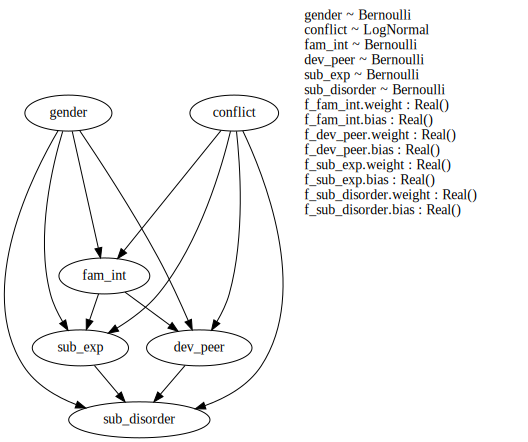

In [4]:
class CausalModel(PyroModule):
    def __init__(self):
        super().__init__()
        self.f_fam_int = PyroModule[nn.Linear](2, 1)
        self.f_dev_peer = PyroModule[nn.Linear](3, 1)
        self.f_sub_exp = PyroModule[nn.Linear](3, 1)
        self.f_sub_disorder = PyroModule[nn.Linear](4, 1)

    def forward(self) -> torch.Tensor:
        gender = pyro.sample("gender", dist.Bernoulli(0.5))
        conflict = pyro.sample("conflict", dist.LogNormal(0, 1))
        
        covariates = torch.cat(torch.broadcast_tensors(
            conflict[..., None], gender[..., None]
        ), dim=-1)
    
        logits_fam_int = self.f_fam_int(covariates)[..., 0]
        fam_int = pyro.sample("fam_int", dist.Bernoulli(logits=logits_fam_int))
        
        covariates_and_treatment = torch.cat(torch.broadcast_tensors(
            conflict[..., None], gender[..., None], fam_int[..., None]
        ), dim=-1)
        
        logits_dev_peer = self.f_dev_peer(covariates_and_treatment)[..., 0]
        dev_peer = pyro.sample("dev_peer", dist.Bernoulli(logits=logits_dev_peer))

        logits_sub_exp = self.f_sub_exp(covariates_and_treatment)[..., 0]
        sub_exp = pyro.sample("sub_exp", dist.Bernoulli(logits=logits_sub_exp))
        
        covariates_and_mediators = torch.cat(torch.broadcast_tensors(
            conflict[..., None], gender[..., None], dev_peer[..., None], sub_exp[..., None]
        ), dim=-1)

        logits_sub_disorder = self.f_sub_disorder(covariates_and_mediators)[..., 0]
        sub_disorder = pyro.sample("sub_disorder", dist.Bernoulli(logits=logits_sub_disorder))

        return sub_disorder

surrogate_model = CausalModel()
pyro.render_model(surrogate_model, render_distributions=True, render_params=True)



## Causal Query: average natural direct effect (ANDE)

In [5]:
def direct_effect(model: Callable, X: str, Z: str) -> Callable:
    def wrapper(x, x_prime):
        with MultiWorldCounterfactual(-2):
            ys = do(actions={X: x})(
                do(actions={X: x_prime})(
                    do(actions={Z: lambda Z_: Z_})(
                        pyro.plate("data", size=x.shape[0], dim=-1)(
                            model))))()
        
            return ys
    return wrapper

We can apply this directly to the causal model defined above to get a new model representing the joint distribution over all factual and counterfactual variables necessary to estimate the NDE:

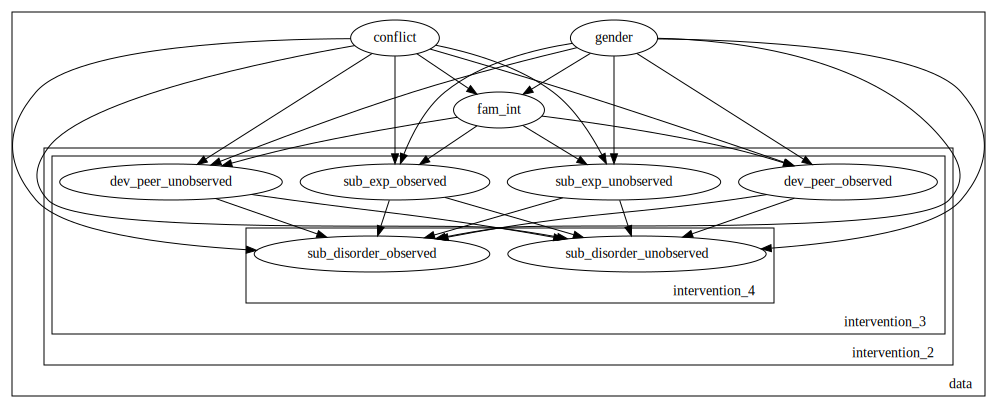

In [6]:
x0 = data["fam_int"].new_full((num_data,), 0.)
x1 = data["fam_int"].new_full((num_data,), 1.)

query_model = direct_effect(surrogate_model, "fam_int", "sub_exp")

pyro.render_model(query_model, (x0, x1))

A quantity complementary to the direct effect is the indirect effect:

$$IE ( Y; x, x' ) = \mathbb{E} [ Y_{X=x', Z=Z_{X=x}} - \mathbb{E} [ Y_{X=x} ] ]$$

Interestingly, the indirect effect is also computable from the same query operation under `MultiWorldCounterfactual`.

# Inference

Before attempting to compute the natural direct effect, we first learn the model's parameters.

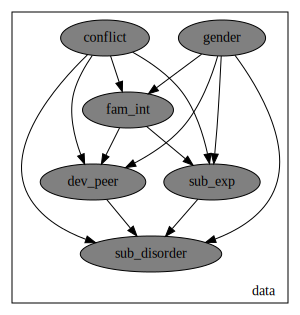

In [7]:
conditioned_model = pyro.condition(data=data)(
    pyro.plate("data", size=num_data, dim=-1)(
        surrogate_model
    )
)

pyro.render_model(conditioned_model)

In [8]:
pyro.clear_param_store()

guide = pyro.infer.autoguide.AutoDelta(conditioned_model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = pyro.infer.SVI(conditioned_model, guide, adam, loss=pyro.infer.Trace_ELBO())
num_iterations = 1500
for j in range(num_iterations):
    loss = svi.step()
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j, loss / len(data)))

[iteration 0000] loss: 368.0111
[iteration 0100] loss: 326.8923
[iteration 0200] loss: 325.8086
[iteration 0300] loss: 325.3414
[iteration 0400] loss: 325.1151
[iteration 0500] loss: 325.0236
[iteration 0600] loss: 324.9916
[iteration 0700] loss: 324.9818
[iteration 0800] loss: 324.9792
[iteration 0900] loss: 324.9786
[iteration 1000] loss: 324.9785
[iteration 1100] loss: 324.9785
[iteration 1200] loss: 324.9785
[iteration 1300] loss: 324.9785
[iteration 1400] loss: 324.9785


Now we can use the expanded model defined previously to get the natural direct effect:

In [12]:
conditioned_query_model = pyro.condition(data=covariates)(
    pyro.condition(data={"fam_int": data["fam_int"]})(  # TODO remove this line which has no effect on inference
        query_model))

discrete_posterior = pyro.infer.infer_discrete(first_available_dim=-6)(
    pyro.infer.config_enumerate()(
        conditioned_query_model))

predictive = pyro.infer.Predictive(conditioned_query_model, guide=discrete_posterior, num_samples=500)
predictive_samples = predictive(x0, x1)

ys_all = predictive_samples["sub_disorder_unobserved"]
ys_xprime = ys_all[..., 1, 1, 0, :]  # TODO is this indexing into the right world?
ys_x = ys_all[..., 0, 0, 1, :]  # TODO is this indexing into the right world?
individual_NDE_samples = ys_xprime - ys_x

# Evaluation

We can compute the natural direct effect from samples of the posterior distribution over the potential outcomes:
-.055 wtih ci -.12, .01

tensor(-0.0374)


(array([ 1.,  4.,  8.,  5., 12., 19., 22., 26., 38., 47., 70., 39., 49.,
        28., 21.,  7.,  7.,  3.,  2.,  2.]),
 array([-0.1   , -0.0938, -0.0876, -0.0814, -0.0752, -0.069 , -0.0628,
        -0.0566, -0.0504, -0.0442, -0.038 , -0.0318, -0.0256, -0.0194,
        -0.0132, -0.007 , -0.0008,  0.0054,  0.0116,  0.0178,  0.024 ],
       dtype=float32),
 <BarContainer object of 20 artists>)

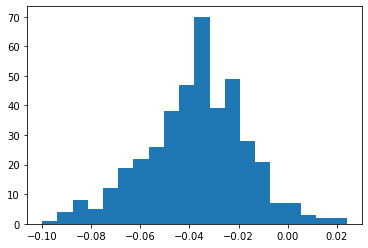

In [13]:
import matplotlib.pyplot as plt

individual_NDE_mean = torch.mean(individual_NDE_samples, dim=0)
NDE_samples = torch.mean(individual_NDE_samples, dim=-1)  # avg over datapoints
NDE_mean = torch.mean(NDE_samples, dim=0)  # avg over posterior samples
print(NDE_mean)
plt.hist(individual_NDE_mean.detach().cpu().numpy(), bins=20)